[GRxnODE Github Link.](https://github.com/Long1Corn/GRxnODE)


This demo includes a brief tutorial for GRxnODE:
1. Dataset requirements
2. How to train a GRxnODE model
3. How to extract kinetics and RTD from a trained model and Visualization
4. How to use a trained model to predict the dynamic response of unseen input conditions.




![image](Demo/Picture3.jpg)


Let's first explain the dataset that is requried to model the dynamic behaviours of a reactor (to train GRxnODE).

The essential information should be the reactor input and output conditions. For example, we need to know the feed compositions over time yin(t) and exit compositions over time yout(t).

To store both time and composition, yin(t) is a 2D array ([time, comp1, comp2, ..., compN]), where the first column contains time, and the rest columns contains compositions of different reactants at the corresponding time.

Similarly, yout(t) has the same shape and structure as yin(t).

However, sometimes external variables can also impact kinetics or RTD profile, so we introduce theta(t) to store the information.

All the information will be regarded as on dataset and be sent to GRxnODE as a dict:


        dataset = {"time_data"  :   time data of yout [1*L array],
                   "yout_data"  :   compostions data of yout [N*L array]
                   "p_data"     :   process inputs that will change with time [list]
                   "y0_data"    :   inital conditions in the reactor [k*N array]}

        where   L is the length of yout(t);
                N is the number of reactants;
                k is the segmentations of the hypothetic FPR.

        "p_data" by default contains yin(t) and one external variable F(t) where F is feed flow rate.
        p_data = [yin(t), F(t)]


Now let's visualize two datasets from an ideal CSTR and a complex reaction network involving 3 reactants.

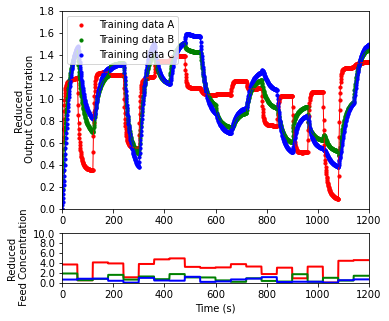

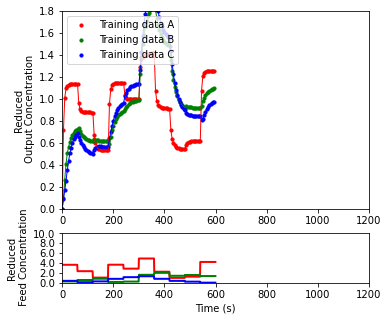

In [1]:
from Data.CSTR_ideal import get_data
from Engine.data_visualizer import data_vis

trainset_1, testset_1, data_scale = get_data(f=1, s=5)

data_vis(trainset_1)
data_vis(testset_1)

n these two datasets, multiple step changes is applied to the input concentrations, and the corresponding dynamic reactor outputs is recorded.

We then use these two datasets as train and test set to train a GRxnODE model for this CSTR and reaction.


In [2]:
import Engine.Trainer as Trainer
from Engine.cfg import CFG

cfg = CFG() # cfg contains default trainer settings and model parameters
trainsets = [trainset_1, ]
testsets = [testset_1, ]    # now we only have one train set and one test set

cfg.ode_rtol = 0.01
cfg.ode_atol = 0.001    # set a larger ODE solver tolerance to speedup
cfg.epoch = 300     # use a smaller epoch to speed up
cfg.lr_step_size = [200, ]  # reduce learning rate and 200 epoch

cfg.model_in_var = 3    # we have 3 reactants in yin(t)
cfg.model_hidden_var = 24
cfg.model_out_var = 3    # we have 3 reactants in yout(t)

trainer = Trainer.RTD(cfg, trainsets, testsets) # send configurations, train and test set to trainer
trainer.train() # start training

D:\Pyprojects\GRxnODE\Model_Zoo\Model_Zoo.py:45: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is C:\Users\56504\AppData\Local\Temp/torch/kernels. This warning will appear only once per process. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cuda\jit_utils.cpp:860.)
  RTD_r = self.t ** (n - 1) / torch.lgamma(n).exp() * (n ** n) * (-self.t * n).exp()


itr:10  time:(1m 43s) loss:0.5287 lr:0.0050 0.0100
Test error = 0.5044
itr:20  time:(3m 24s) loss:0.3678 lr:0.0050 0.0100
Test error = 0.4603
itr:30  time:(5m 7s) loss:0.2659 lr:0.0050 0.0100
Test error = 0.3094
itr:40  time:(6m 54s) loss:0.1694 lr:0.0050 0.0100
Test error = 0.2090
itr:50  time:(8m 38s) loss:0.1437 lr:0.0050 0.0100
Test error = 0.1883
itr:60  time:(10m 23s) loss:0.1388 lr:0.0050 0.0100
Test error = 0.1876
itr:70  time:(12m 9s) loss:0.1373 lr:0.0050 0.0100
Test error = 0.1755
itr:80  time:(13m 55s) loss:0.1239 lr:0.0050 0.0100
Test error = 0.1372
itr:90  time:(15m 36s) loss:0.1050 lr:0.0050 0.0100
Test error = 0.1100
itr:100  time:(17m 21s) loss:0.0830 lr:0.0050 0.0100
Test error = 0.0774
itr:110  time:(19m 6s) loss:0.0771 lr:0.0050 0.0100
Test error = 0.1069
itr:120  time:(20m 50s) loss:0.0856 lr:0.0050 0.0100
Test error = 0.1130
itr:130  time:(22m 36s) loss:0.0895 lr:0.0050 0.0100
Test error = 0.0962
itr:140  time:(24m 19s) loss:0.0858 lr:0.0050 0.0100
Test error = 0.

After 300 epoch, we get 0.0277 normalized MAE on the test set, not bad.

Let's then visualize the reaction kinectics and RTD profile learned by the GRxnODE

D:\Pyprojects\GRxnODE\Model_Zoo\Model_Zoo.py:45: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is C:\Users\56504\AppData\Local\Temp/torch/kernels. This warning will appear only once per process. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cuda\jit_utils.cpp:860.)
  RTD_r = self.t ** (n - 1) / torch.lgamma(n).exp() * (n ** n) * (-self.t * n).exp()


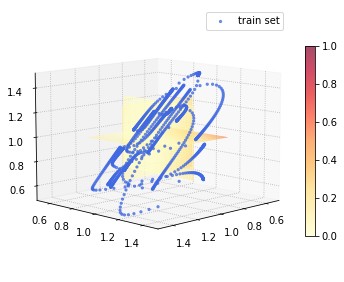

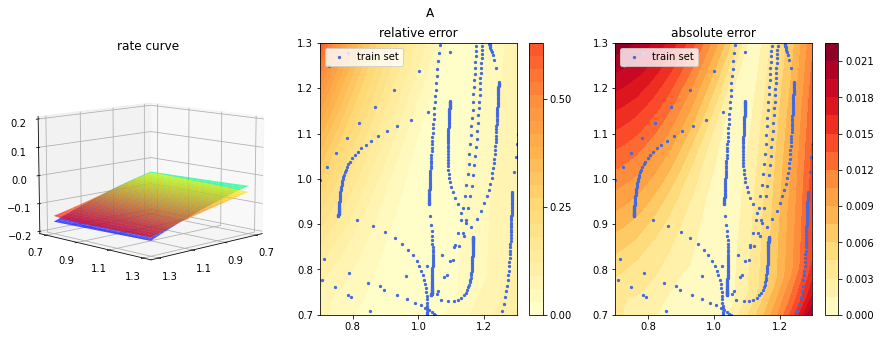

<Figure size 432x288 with 0 Axes>

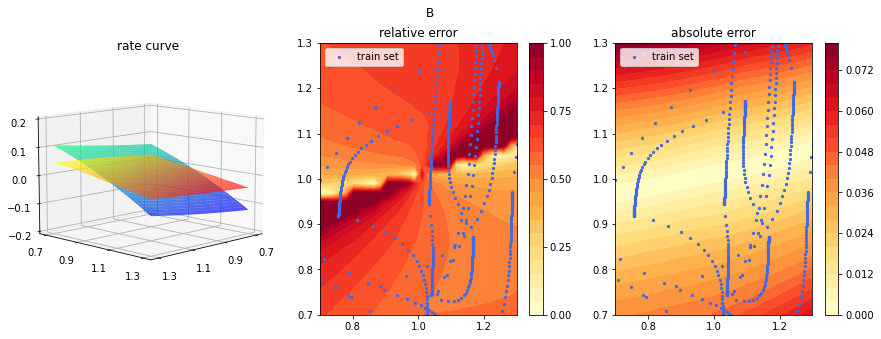

<Figure size 432x288 with 0 Axes>

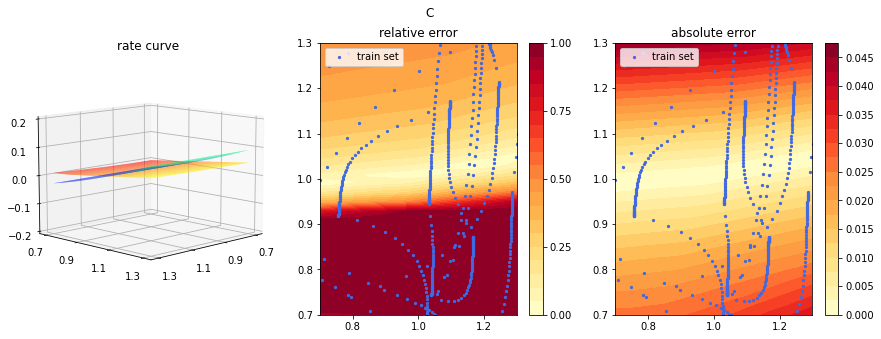

<Figure size 432x288 with 0 Axes>

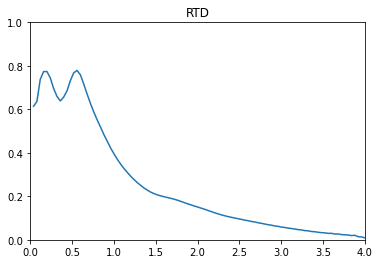

In [1]:
from Engine.model_visualizer import Visualizer
import torch


model_path = r"output/test_model.pth"  # the path to the trained GRxnODE model
trainer.model.load_state_dict(torch.load(model_path)) # load the trained GRxnODE model

visualizer = Visualizer(trainer.model, trainsets, data_scale, cfg)
visualizer.run()  # run the visualizer

By comparing the learned kinetics and the true kinetics, we found that GRxnODE can predict the reaction rates of all three reactant and different compositions pretty well.

For the RTD profile, it is close to the RTD of an ideal CSTR.

It should be noted that smaller ODE solver tolerance and larger epoch can be used to get better results.



Let then use the trained model to predict the reactor behavior. For simplicity, we will use the previous test set as example.

D:\Pyprojects\GRxnODE\Model_Zoo\Model_Zoo.py:45: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is C:\Users\56504\AppData\Local\Temp/torch/kernels. This warning will appear only once per process. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cuda\jit_utils.cpp:860.)
  RTD_r = self.t ** (n - 1) / torch.lgamma(n).exp() * (n ** n) * (-self.t * n).exp()


prediction complete


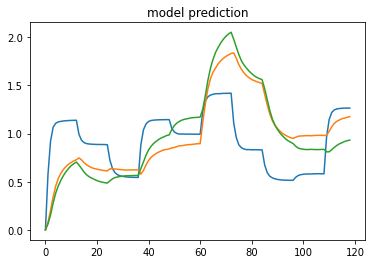

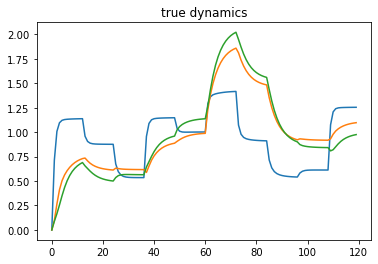

In [1]:
import Engine.Trainer as Trainer
from Engine.cfg import CFG
from Data.CSTR_ideal import get_data
import torch
import matplotlib.pyplot as plt

cfg = CFG()
trainer = Trainer.RTD(cfg, None, None)

model_path = r"output/test_model.pth"
trainer.model.load_state_dict(torch.load(model_path))



trainset_1, testset_1, data_scale = get_data(f=1, s=5)

true_dynamics = testset_1["y_data"].squeeze()
del testset_1["y_data"]

predictions = trainer.predict([testset_1]) # send the test dataset to the trained GRxnODE, here yout data is not required for prediction

plt.plot(predictions[0])  # let plot the model predictions
plt.title("model prediction")
plt.show()


plt.plot(true_dynamics) # let plot the true dynamics for comparison
plt.title("true dynamics")
plt.show()

The model prediction is not bad.

Here ends this demo.